### Importing the Necessary Libraries

### 1. Data Preprocessing
#### Loading the Data

In [22]:
import pandas as pd
import re
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import nltk
from langdetect import detect, LangDetectException
import contractions
from collections import Counter

In [23]:
import json
with open('DB_reddit.json', 'r', encoding='utf-8') as file:
    reddit = json.load(file)

# Converting the data into a DataFrame 
df = pd.DataFrame(reddit)
df.head()


,title,score,date,url,num_comments,comments
0,Not under David Beckhams watch,65534,2023-10-06 17:16:05,https://v.redd.it/0mmzjpgdyisb1,2042,"[Please report rule breaking posts, such as:\n..."
1,David Beckham is not letting this go...,29482,2024-01-02 14:44:45,https://i.redd.it/dowdawvo7y9c1.jpeg,982,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
2,David and Victoria Beckham finally addressing ...,800,2023-10-05 20:46:41,https://v.redd.it/ahnysog1vcsb1,261,[I think if they hadn’t brought this up in a d...
3,Victoria Beckham shares photo of husband David...,2687,2023-12-16 10:45:59,https://i.redd.it/nd35a08lpj6c1.jpeg,298,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
4,Micah Richards on David Beckham,5650,2024-09-19 18:27:36,https://v.redd.it/7o6n7df28qpd1,256,[**Mirrors / Alternative Angles**\n \n\n*I am...


#### Check for Missing Values

In [24]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Display missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
title           0
score           0
date            0
url             0
num_comments    0
comments        0
dtype: int64


#### Check for Duplicate Values

In [25]:
duplicates = df.duplicated(subset=['url']).sum()
print(f"Number of duplicate rows: {duplicates}")
df.drop_duplicates(subset=['url'], inplace=True)

Number of duplicate rows: 0


#### Advance Preprocessing

In [26]:
# Function to clean text
def clean_text(text):
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Removing special characters 
    text = re.sub(r"[^a-zA-Z0-9'\s]", '', text)
    # Converting to lowercase
    text = text.lower()
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to detect if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

In [27]:
# Cleaning and preprocess titles
df['Cleaned_Title'] = df['title'].apply(lambda x: expand_contractions(clean_text(str(x))) if is_english(str(x)) else '')

# Preprocessing each comment within the list
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [expand_contractions(clean_text(comment)) for comment in comments if is_english(comment)])


#### Stopwords Removal

In [28]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_tokens(tokens):
    # Remove stopwords and lemmatize
    tokens = [word for word in tokens if word not in stop_words]
    # If no tokens are left after stopword removal, return the original tokens
    if not tokens:
        return tokens
    return [lemmatizer.lemmatize(word) for word in tokens]

#### Tokenization and Lemmatization

In [29]:
# Tokenize and lemmatize the cleaned text
df['Title_Tokens'] = df['Cleaned_Title'].apply(lambda x: process_tokens(word_tokenize(x)))
df['Comments_Tokens'] = df['Cleaned_Comments'].apply(lambda comments: [process_tokens(word_tokenize(comment)) for comment in comments])



In [30]:
# Display the processed data
processed_columns = ['title', 'Cleaned_Title', 'Title_Tokens', 'comments', 'Cleaned_Comments', 'Comments_Tokens']
print("\nProcessed Data:")
print(df[processed_columns].head(10))


Processed Data:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   
5                                Young David Beckham   
6                         Thoughts on David Beckham?   
7  david beckham: then vs now – is it just me or ...   
8                          David Beckham is autistic   
9  David and Victoria Beckham recreate their wedd...   

                                       Cleaned_Title  \
0                                                      
1               david beckham is not letting this go   
2  david and victoria beckham finally addressing ...   
3  victoria beckham shares photo of husband david...   
4                    micah richards on david beckham   
5                             

#### Term Frequency

In [31]:
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

def process_text(text, lemmatizer, stopwords_set):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

term_freq_counter = Counter()

# Processing each row in the DataFrame and updating term frequency counts
for _, row in df.iterrows(): 
    tokens_title = process_text(row['Cleaned_Title'], lemmatizer, stopwords_set)
    tokens_comments = [word for comment in row['Cleaned_Comments'] for word in process_text(comment, lemmatizer, stopwords_set)]

    # Updating term frequency counts
    term_freq_counter.update(tokens_title)
    term_freq_counter.update(tokens_comments)

# Displaying the most common terms
freq_num = 50  
print(f"Top {freq_num} most common terms:")
for term, count in term_freq_counter.most_common(freq_num):
    print(f"{term}: {count}")

Top 50 most common terms:
like: 2623
would: 1827
people: 1739
think: 1396
one: 1357
know: 1189
look: 1129
class: 1110
get: 1088
beckham: 1073
time: 999
really: 912
even: 910
david: 849
good: 839
also: 821
make: 804
year: 796
thing: 780
much: 771
love: 720
still: 702
way: 697
's: 681
never: 671
could: 668
see: 622
working: 618
well: 613
going: 605
money: 598
say: 580
always: 564
lol: 563
got: 558
go: 552
lot: 542
want: 530
right: 517
victoria: 511
work: 510
mean: 506
someone: 506
u: 503
woman: 467
man: 459
said: 459
back: 455
made: 448
though: 444


# WordCloud of Sentiment Heavy Words and Entities

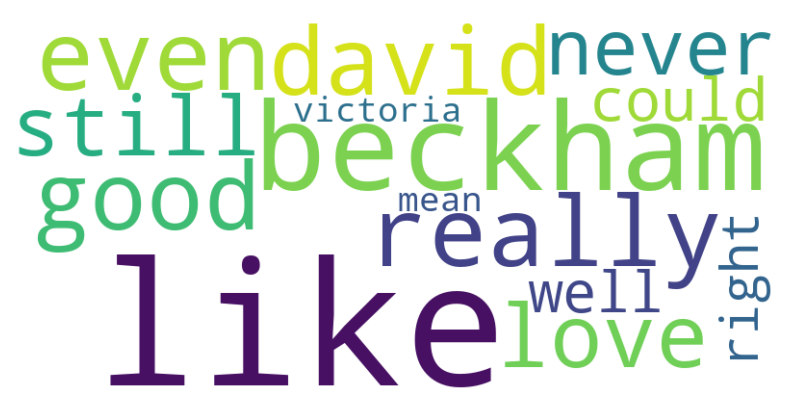

In [32]:
# Visualizing the sentiment heavy words and entities by WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionary with sentiment heavy words and entities and their frequencies as values
words_freq = {
    "like": 2627,
    "beckham": 1077,
    "really": 912,
    "even": 911,
    "good": 844,
    "david": 848,
    "love": 720,
    "still": 702,
    "never": 671,
    "could": 669,
    "well": 614,
    "right": 517,
    "victoria": 512,
    "mean": 504
}
    

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)

# Plotting the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hiding axes
plt.show()


# Bar Chart of Sentiment Heavy Words and Entities with their frequencies

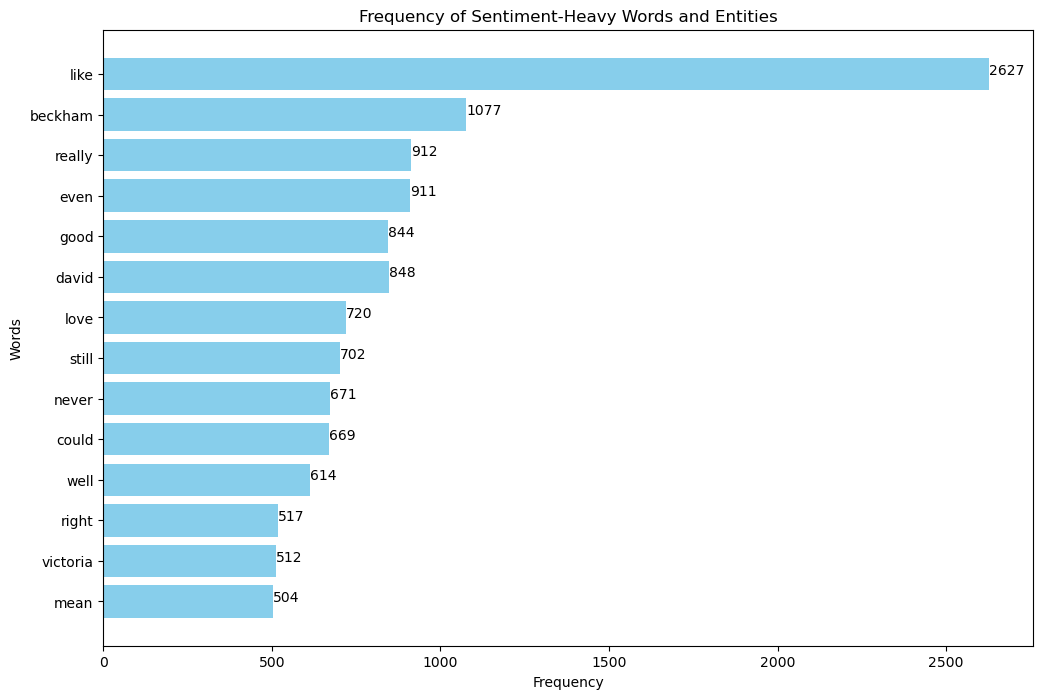

In [33]:
# Visualizing the sentiment heavy words and entities and their frequencies as values

# List of words and their frequencies
words = [
    'like', 'beckham', 'really', 'even', 'good', 'david', 'love', 
    'still', 'never', 'could', 'well', 'right', 'victoria', 'mean'
]

frequencies = [
    2627, 1077, 912, 911, 844, 848, 720, 
    702, 671, 669, 614, 517, 512, 504
]


# Plotting the bar chart
plt.figure(figsize=(12,8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency of Sentiment-Heavy Words and Entities')
plt.gca().invert_yaxis()  # Inverting y axis to have the most frequent word on top

# Adding frequencies next to the bars  # Adding frequencies next to the bar
for index, value in enumerate(frequencies):
    plt.text(value, index, str(value))
plt.show()


# Tfidf Vectorization

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for Pre-processing text by removing numbers
def preprocess_text(text):
    return re.sub(r'\d+', '', text)  

# loading data from json file
with open('DB_reddit.json', 'r', encoding='utf-8') as f:
    posts_data = json.load(f)

    comments = []
    for post in posts_data:
        for comment in post['comments']:
            preprocessed_comment = preprocess_text(comment)  # Preprocessing the comments
            comments.append(preprocessed_comment)  # Storing preprocessed comments

# Converting the comments into a dataframe
df = pd.DataFrame(comments, columns=['Cleaned_Comments'])
            
# Checking the dataframe
print("DataFrame preview (first 5 rows):")
print(df.head()) 

# Adjusting the token pattern to exclude purely numerical tokens and refining the ngram range
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',  # Excludes purely numeric tokens and requires at least three characters
    ngram_range=(1,2),  #unigram and bi-gram
    min_df=10,  # Increase min_df to reduce features that appear rarely
    max_df=0.5 # Lower max_df to exclude terms that are too common

)
   
# Fitting and transforming the comments into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Comments']).toarray()

# Converting to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

DataFrame preview (first 5 rows):
                                    Cleaned_Comments
0  Please report rule breaking posts, such as:\n\...
1                         David ain't fuckin' around
2  David Beckham actually grew up working class s...
3           Well, she wasn’t Poor Spice for a reason
4  David Beckham is pissed because he is actually...
   ability  able  absolute  absolutely     abuse  accent   account  act  \
0      0.0   0.0       0.0         0.0  0.312261     0.0  0.152936  0.0   
1      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
2      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
3      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
4      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   

   acting   action  ...  year old  years  years ago  yep  yes  young  younger  \
0     0.0  0.13697  ...       0.0    0.0        0.0  0.0  0.0    0.0      0.0   
1     0.0  0.00000  ...       0.0  

# Vader Sentiment Analysis

In [38]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initializing VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis with error handling
def analyze_sentiment(text):
    if text:  # Checking if text is not empty or None
        try:
            sentiment = analyzer.polarity_scores(text)
            return sentiment['compound']  # Compund score represents overall sentiment
        except Exception as e:
            print(f"Error analyzing sentiment: {e}")
            return None  # Return None if there's an error
    else:
        return None  # Return None for empty or None text

# Applying sentiment analysis
df['sentiment_score'] = df['Cleaned_Comments'].apply(analyze_sentiment)

# Categorize sentiment based on the score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Printing results
print("DataFrame with sentiment scores and categories (first 5 rows):")
print(df[['Cleaned_Comments', 'sentiment_score', 'sentiment_category']].head())

DataFrame with sentiment scores and categories (first 5 rows):
                                    Cleaned_Comments  sentiment_score  \
0  Please report rule breaking posts, such as:\n\...          -0.9505   
1                         David ain't fuckin' around           0.0000   
2  David Beckham actually grew up working class s...           0.0000   
3           Well, she wasn’t Poor Spice for a reason          -0.2500   
4  David Beckham is pissed because he is actually...          -0.6369   

  sentiment_category  
0           negative  
1            neutral  
2            neutral  
3           negative  
4           negative  


# Visualizing sentiment score distribution by histogram and density plot

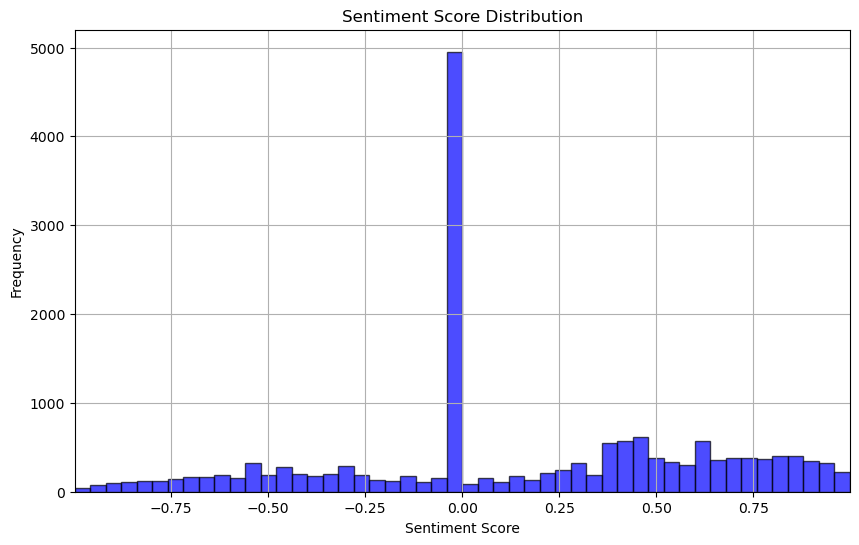

C:\Users\Saurabh Sharma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


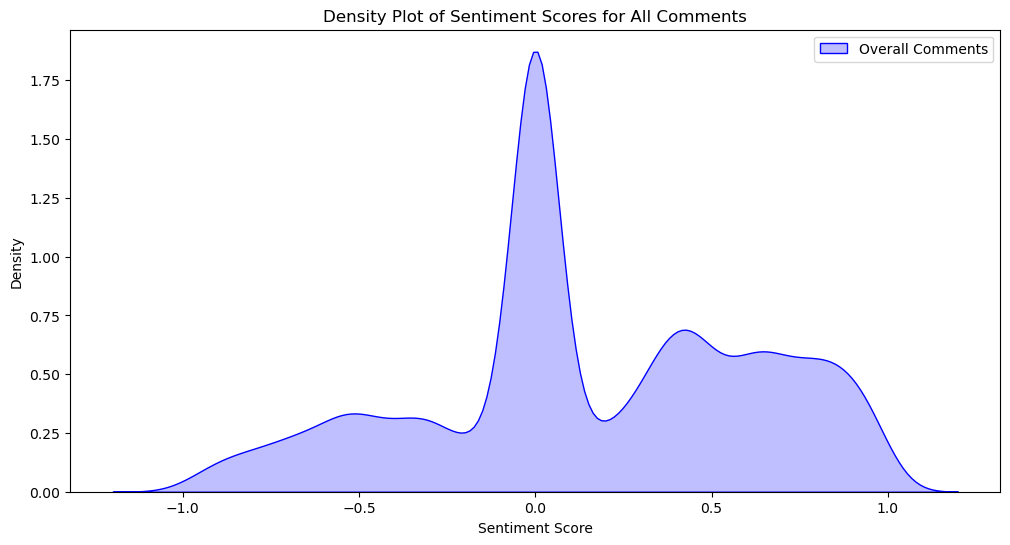

In [39]:
#Visualizing sentiment score distribution by histogram and density plot

num_bins = 50  # Number of bins

# Plotting sentiment score distribution
plt.figure(figsize=(10,6))
plt.hist(df['sentiment_score'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.grid(True)   # For better readability

# Setting plot titles and labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')

# Setting x and y limits
plt.xlim(df['sentiment_score'].min(), df['sentiment_score'].max())  
plt.ylim(0, plt.ylim()[1])  # Ensuring y axis starts from 0 and is correclty scaled

plt.show()


# Plotting density of sentiment scores for all comments
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df['sentiment_score'], fill=True, color='blue', label='Overall Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores for All Comments')
plt.legend()
plt.show()

# Word Cloud for overall comments

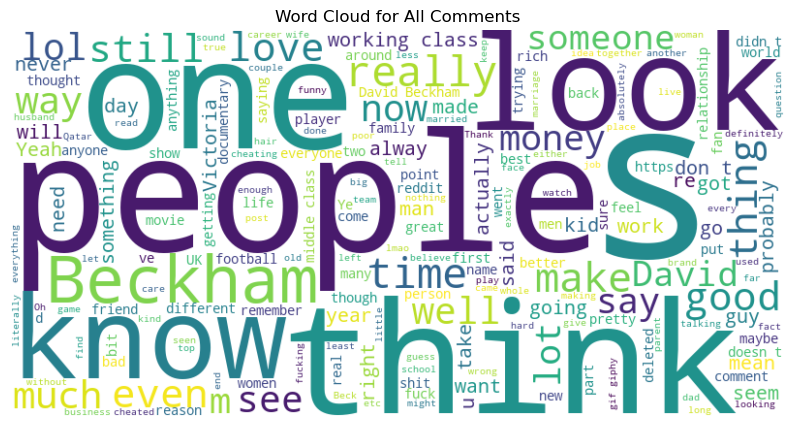

In [40]:
# Word Cloud for overall comments

from wordcloud import WordCloud, STOPWORDS
all_comments = ' '.join(df['Cleaned_Comments']) 

# Generating word cloud with custom settings
wordcloud = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=set(STOPWORDS), max_words=200, colormap='viridis'
).generate(all_comments)

# Displaying the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Word Cloud for All Comments')
plt.show()
